# Recommender Systems

Two most common recommender systems:
1. Content-based: focus on the attributes of the items, recommendations given **based on the similarities between the items**
2. Collaborative Filtering (CF): "wisdom of the crowd" is used to recommend items, i.e., **users' attitude towards items is used** (e.g., rating on Amazon).

**Collaborative Filtering** (CF) is more common, because it gives better results. The algorithm learns which features to use. It can be subdivided into two sub-categories:
- Memory-Based collaborative filtering: Singular Value Decomposition (SVD)
- Model-Based collaborative filtering: Cosine similarity

Drawback of memory-based CF:
- it doesn't scale to real-world scenarios
- and doesn't address the well-known **cold-start problem**: when new user or new item enters the system.

Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer the cold-start problem.

Hybrid Recommender Systems use both Collaborative Filtering and Content-based Models and usually have a higher accuracy. They can tackle the cold-start problem better by using metadata.

Each method is described below.

Note: very interesting post on recommender systems:
[Ethan Rosenthal, Intro to Recommender Systems: Collaborative Filtering](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)

## 1. Content-based Recommender System

Item similarity recommendation system.

We will use famous MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. It contains 100k movie ratings from 943 users and a selection of 1682 movies. The dataset can be downloaded from [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip). You can read a brief description of the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

### Data exploration

In [1]:
import numpy as np
import pandas as pd

In [8]:
# Load user data
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/u.data', sep='\t', names=column_names)

In [9]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [10]:
# Load movies
movie_titles = pd.read_csv("data/Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [11]:
# Merge both users and movies on item_id
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
sns.set_style('white')

In [20]:
# Movies with best average ratings
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [21]:
# But how many ratings do we have?
# Not only the average rating is important, but also how many people rated it
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [26]:
# We assemble our data frame with average ratings and number of ratings
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [27]:
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [28]:
ratings['num of ratings'] = df.groupby('title')['rating'].count()

In [29]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


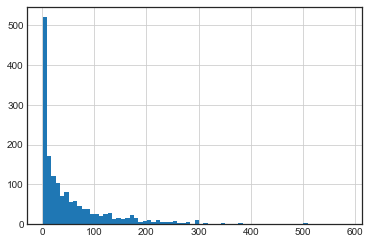

In [31]:
# Histogram of num of ratings
# Most movies have few ratings
ratings['num of ratings'].hist(bins = 70)

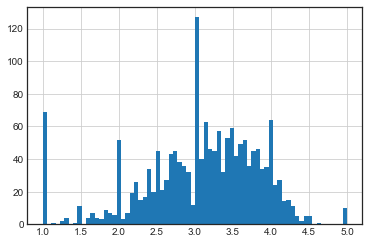

In [32]:
# Histogram of rating averages
# Rating is more normally distributed
ratings['rating'].hist(bins = 70)

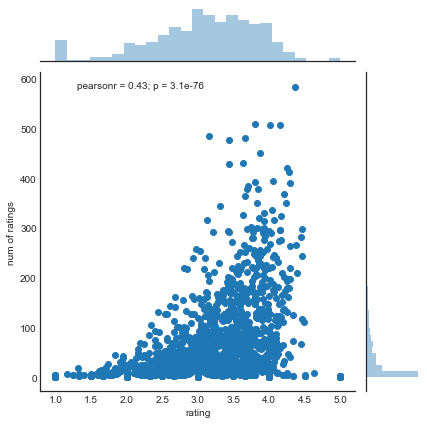

In [34]:
# Both histograms together
# There seems to be a relationship between the average rating and the num of ratings
# It makes sense: good movies are more watched and get higher ratings
sns.jointplot(x='rating',y='num of ratings',data=ratings)

### Recommender system

In [39]:
# First, we create a pivot table with user_id vs title and rating as value
# We'll have many NaNs, because most movies haven't been seen by all users
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')

In [38]:
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# We choose two of the most voted movies
# Example: these can be: Star Wars & Liar Liar
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [42]:
# Series/Columns of user_id rating for each of the chosen movies
startwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

In [43]:
startwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [45]:
# We can treat those columns as vectors:
# The ratings all the users gave to that movie
# We find correlations of this vector to other vector movies!
# pd.corrwith() computes pairwise correlations between rows/cols of two data frames
similar_to_starwars = moviemat.corrwith(startwars_user_ratings)

In [46]:
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [47]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/Users/mxagar/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2517: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/mxagar/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2446: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [63]:
# We have many NaN values, we clean all that
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [64]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)

In [65]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [66]:
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


In [67]:
# Now we can sort the resulting correlation vectors
corr_starwars.sort_values(by='Correlation',ascending=False).head()

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0


In [68]:
# We get results that don't make sense
# because the number of votes/ratings is not taken into account!
# We fix that by filtering movies that only have more ratings than a threshold

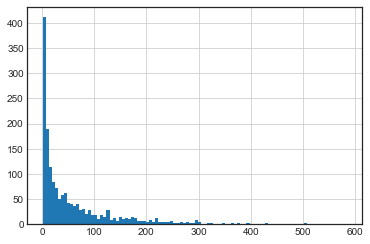

In [69]:
# We see that after 100 ratings there is a decline in the histogram of ratings
# Maybe that's a starting point for the threshold
# Although we should manually test what happens when we change that threshold value
ratings['num of ratings'].hist(bins = 100)

In [70]:
# We join the number of ratings value to the corr columns
# We can do that easily because the index is the same for both
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])

In [73]:
# Now we filter out movies with the threshold
# And we get our results!
# We can change the threshold and see what happens
# We see that the correlation values decrease fast
corr_starwars[corr_starwars['num of ratings'] > 100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [74]:
corr_liarliar[corr_liarliar['num of ratings'] > 100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102


## 2. Collaboration Filtering

We will use famous MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. It contains 100k movie ratings from 943 users and a selection of 1682 movies. The dataset can be downloaded from [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip). You can read a brief description of the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

### Load and prepare data

In [75]:
import numpy as np
import pandas as pd

In [77]:
# Load user ratings of each movie id
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/u.data', sep='\t', names=column_names)

In [78]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [80]:
# Load movie titles of each movie id
movie_titles = pd.read_csv("data/Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [81]:
# Merge both tables: movie title - user ratings
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [83]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


In [116]:
# Train & Test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)

In [117]:
train_data.shape

(75002, 5)

In [118]:
test_data.shape

(25001, 5)

### 2.1 Memory-based Collaborative Filtering

We do two types of predictions:
* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

In [85]:
train_data.head()

,user_id,item_id,rating,timestamp,title
10752,350,515,5,882346756,"Boot, Das (1981)"
1382,74,302,4,888333219,L.A. Confidential (1997)
86754,280,544,4,891701302,Things to Do in Denver when You're Dead (1995)
67741,625,91,4,891263057,"Nightmare Before Christmas, The (1993)"
59354,311,739,4,884365823,Pretty Woman (1990)


In [106]:
# We create a n_users x n_items matrix such that
# (user_id,item_id) = rating (for both the train and test splits)
# Here it is created with a for loop, 
# but note that above we created it with pandas built-in functions
# HOWEVER, IMPORTANT NOTE:
# Both train and test matrices have the same size!
# Both are very sparse and contain some of all the data points from the original df
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [108]:
train_data_matrix.shape

(944, 1682)

In [119]:
train_data_matrix[:5,:5]

array([[0., 0., 4., 3., 3.],
       [4., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0.]])

In [121]:
test_data_matrix.shape

(944, 1682)

In [122]:
test_data_matrix[:5,:5]

array([[5., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [88]:
# We compute pairwise similarities = distances between rows of the matrices
# The selected distance metric is the cos(angle) between the pair of vectors
# Basically, two rows vectors are taken and their cos(angle) is obtained from their dot product
# Other metric are possible: 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', ...
# We do that for users -> we obtain a n_users x n_users cosine similarity matrix
# and for items (movies) -> we obtain a n_items x n_items cosine similarity matrix
# NOTE 1: in the previous section we had correlations: 1 movie against all other movies,
# now we have cosine similarities movie-movie, user-user
# NOTE 2: cos in [-1,1], but here [0,1] because we have non negative ratings;
# more similar vectors have cos -> 1, but distance -> 0
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [90]:
# user vs user similarity: 944 users
# THIS IS THE TRAINED SIMILARITY MATRIX USED FOR PREDICTION (one of two)
user_similarity.shape

(944, 944)

In [101]:
# item vs item similarity: 1682 items
# THIS IS THE TRAINED SIMILARITY MATRIX USED FOR PREDICTION (one of two)
item_similarity.shape

(1682, 1682)

In [104]:
# Why is diagonal 0, shouldn't it be cos(0) = 1?
# I understand the output of pairwise_distances is not the cosine, but the complementary,
# because we're measuring DISTANCE: higher cos values indicate higher distances, thus sign(cos)*(1 - abs(cos)) is the distance?
user_similarity[:5,:5]

array([[0.        , 0.8879125 , 0.96135669, 0.91793088, 0.73553204],
       [0.8879125 , 0.        , 0.92580484, 0.90095429, 0.92705793],
       [0.96135669, 0.92580484, 0.        , 0.76950764, 0.97416351],
       [0.91793088, 0.90095429, 0.76950764, 0.        , 0.98447948],
       [0.73553204, 0.92705793, 0.97416351, 0.98447948, 0.        ]])

In [105]:
# Why is diagonal 0, shouldn't it be cos(0) = 1?
# See the comment above
item_similarity[:5,:5]

array([[0.        , 0.70022494, 0.77378776, 0.66846564, 0.78716381],
       [0.70022494, 0.        , 0.81328302, 0.65349824, 0.81188045],
       [0.77378776, 0.81328302, 0.        , 0.7446977 , 0.84828264],
       [0.66846564, 0.65349824, 0.7446977 , 0.        , 0.69333802],
       [0.78716381, 0.81188045, 0.84828264, 0.69333802, 0.        ]])

In [92]:
# Prediction function:
# 1. Item-Item Collaborative Filtering: "Users who liked this item also liked ..."
#   MatrixRatingPrediction(user,item) = MatrixRating(user,item) * MatrixSimilarity(item,item)
# Then, each column (item) is scaled by the sum of item similarities in the column, otherwise we don't weight values correctly
#   MatrixRatingPrediction(user,item) *= 1 / sum(abs(MatrixSimilarity(:,item)))
# 2. User-Item Collaborative Filtering: "Users who are similar to you also liked ...""
# Now is similar, but users cana have different rating scales: 
# 'good' might not be the same rating for two users (eg, 3 for one, 4 for the other)
# Therefore, a relative difference is summed to an average:
#   MatrixMeanRating(user) = mean(MatrixRating(user,item),across all items)
# The user mean is subtracted (to each user) from the user ratings
#   MatrixRatingDiff(user,item) = MatrixRating(user,item) - MatrixMeanRating(user)
# Matrix multiplication, as before:
#   MatrixRatingPrediction(user,item) =  MatrixSimilarity(user,user) * MatrixRatingDiff(user,item)
# Scaling, as before, but this time rows are scaled?
#   MatrixRatingPrediction(user,item) *= 1 / sum(abs(MatrixSimilarity(:,user)).T
# Finally, the subtracted mean must be added to each user row
#   MatrixRatingPrediction(user,item) += MatrixMeanRating(user)
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [93]:
# RESULT:
# WE PREDICT ALL USER-ITEM RATINGS BASED ON THE SIMILARITY MATRICES
# It is like extrapolating rating based on 2 heuristics
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [95]:
item_prediction.shape

(944, 1682)

In [97]:
user_prediction.shape

(944, 1682)

In [99]:
item_prediction[:5,:5]

array([[0.38434525, 0.40053006, 0.40718786, 0.37945188, 0.41084638],
       [0.09061954, 0.10365994, 0.09975387, 0.10048604, 0.10347621],
       [0.0694282 , 0.07282982, 0.0704078 , 0.07196383, 0.07258127],
       [0.02735637, 0.02969379, 0.02960594, 0.02913027, 0.03017523],
       [0.19497842, 0.1970268 , 0.21715046, 0.1969409 , 0.21429073]])

In [100]:
user_prediction[:5,:5]

array([[1.5988311 , 0.5797636 , 0.47854012, 0.79922538, 0.48423677],
       [1.2995711 , 0.27229944, 0.13656054, 0.53121973, 0.15350704],
       [1.32339711, 0.23728833, 0.10839534, 0.50151501, 0.11939845],
       [1.25373457, 0.19158923, 0.06696997, 0.45060633, 0.07732139],
       [1.36952525, 0.35745589, 0.26774015, 0.59880353, 0.27163924]])

In [112]:
np.array([np.abs(item_similarity).sum(axis=1)]).shape

(1, 1682)

#### Evaluation

In [ ]:
# We use the Root Mean Squared Error (RMSE)
# RMSE(prediction, true)
# BUT: We had many missing user-item cells, which are 0 now
# Therefore, we need to consider only the non-zero values

In [113]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [115]:
# Heuristic predictions are compared to the ground truth test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1276901352180597
Item-based CF RMSE: 3.453743508800568


### 2.2 Model-based Collaborative Filtering

Model-based collaborative filtering works with matrix factorization: the **Singular Value Decomposition** (SVD) of the user-item-rating matrix is performed to find the latent preferences of users and the latent attributes of items from known ratings.

In (compact) SVD, an `m x n` matrix `X` (user-item, rating) is approximated by `X = U * S * V^T`, where:
* *`U`* is an *`(m x r)`* orthogonal matrix: left singular vectors: **latent/hidden feature vectors related to the users**
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal: the singular values
* *V^T* is an *`(r x n)`* orthogonal matrix: right singular vectors: **latent/hidden feature vectors related to the items**

The value `r` is the rank of `X`, such that `r <= min(m,n)`.
We choose `r` to be of value `k`! The lower it is, the more compressed is the decomposition. It is like choosing the amount of principal components i principal component decomposition (PCA) or eigenvalue computation.

In fact, SVD generalizes the eigenvalue decomposition for non-square matrices. Singular values encode magnitude of the ellipsoid semiaxis, while singular vectors encode direction. Note that in SVD we have two sets of singular vectors: `U` and `V`. So, while in PCA we scale and apply a transformation to our base, in SVD we apply 3 transformations: transform, scale, transform.

In a sparse system, by choosing `k`, we can compress more or less the decomposition of `X` and perform a prediction of it for the missing cells:
`X = U * S * V^T`.

That is the key idea: **we decompose a sparse `X` with SVD and multiply the decomposition matrices `U`, `S`, `V^T` to predict all possible user-item combinations**.

Note that the computation of SVD is quite expensive. State-of-the-art methods use gradient descend methods to find the optimum solution with the minimum error.

In [140]:
# Sparsity:
# 1 - (number of data points / all possible data points)
# 1 - (rows in df / (cells in user-time matrix))
sparsity = round(1.0-len(df)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


In [141]:
# SVD function is taken from scipy, not scikit-learn
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [142]:
# Get SVD components from train matrix.
# Choose k: the number of singular values (= the k largest singular values)
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)

In [125]:
# Predict and evaluate: X = U * S * V^T
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.7177643202049446


In [135]:
# We can plot how RMSE varies with k
# to pick an optimal k (min RMSE)
# However, note that computing SVD is quite expensive...
# Maybe we could compute for max_k and the iterativebly clap/cut the matrices?
error_vector = []
max_k = 100
if max_k > min(train_data_matrix.shape):
    max_k = min(train_data_matrix.shape)
for k in range(1,max_k):
    u, s, vt = svds(train_data_matrix, k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    error = rmse(X_pred, test_data_matrix)
    error_vector.append(error)

In [138]:
error_vector[:5]

[2.9855358191573687,
 2.888897664014669,
 2.8146803934217446,
 2.7808857738144206,
 2.745253408879626]

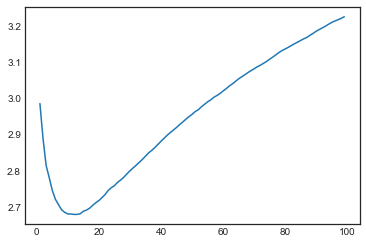

In [137]:
# A value around k = 10 seems to be optimum
plt.plot(range(1,max_k),error_vector)

## More Datasets to Play with

If you want to tackle your own recommendation system analysis, check out these data sets. Note: The files are quite large in most cases, not all the links may stay up to host the data, but the majority of them still work. Or just Google for your own data set!

**Movies Recommendation:**

MovieLens - Movie Recommendation Data Sets http://www.grouplens.org/node/73

Yahoo! - Movie, Music, and Images Ratings Data Sets http://webscope.sandbox.yahoo.com/catalog.php?datatype=r

Jester - Movie Ratings Data Sets (Collaborative Filtering Dataset) http://www.ieor.berkeley.edu/~goldberg/jester-data/

Cornell University - Movie-review data for use in sentiment-analysis experiments http://www.cs.cornell.edu/people/pabo/movie-review-data/

**Music Recommendation:**

Last.fm - Music Recommendation Data Sets http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/index.html

Yahoo! - Movie, Music, and Images Ratings Data Sets http://webscope.sandbox.yahoo.com/catalog.php?datatype=r

Audioscrobbler - Music Recommendation Data Sets http://www-etud.iro.umontreal.ca/~bergstrj/audioscrobbler_data.html

Amazon - Audio CD recommendations http://131.193.40.52/data/

**Books Recommendation:**

Institut für Informatik, Universität Freiburg - Book Ratings Data Sets http://www.informatik.uni-freiburg.de/~cziegler/BX/
Food Recommendation:

Chicago Entree - Food Ratings Data Sets http://archive.ics.uci.edu/ml/datasets/Entree+Chicago+Recommendation+Data
Merchandise Recommendation:

**Healthcare Recommendation:**

Nursing Home - Provider Ratings Data Set http://data.medicare.gov/dataset/Nursing-Home-Compare-Provider-Ratings/mufm-vy8d

Hospital Ratings - Survey of Patients Hospital Experiences http://data.medicare.gov/dataset/Survey-of-Patients-Hospital-Experiences-HCAHPS-/rj76-22dk

**Dating Recommendation:**

www.libimseti.cz - Dating website recommendation (collaborative filtering) http://www.occamslab.com/petricek/data/
Scholarly Paper Recommendation:

National University of Singapore - Scholarly Paper Recommendation http://www.comp.nus.edu.sg/~sugiyama/SchPaperRecData.html
